# Train a ResUnetA model

The notebook performs training of the `ResUnetA` architecture using the `.npz` files prepared in the previous workflows:

This notebook:

 * creates TensorFlow datasets in a k-fold cross-validation scheme, using the npz files previously created. The datasets allow manipulation and loading on the fly, to reduce RAM load and processing of large AOIs
 * performs training of the k-fold models  
 * test the models predictions on a validation batch
 
## NOTE

This workflow can load the `.npz` files from the S3 bucket, or locally. The training will be faster if files are copied and loaded from local disk. Change the `npz_from_s3` flag in the data loader function.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import json
import logging
from functools import reduce
from datetime import datetime
from typing import Callable, Tuple, List

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback

from eoflow.models.metrics import MCCMetric
from eoflow.models.segmentation_base import segmentation_metrics
from eoflow.models.losses import JaccardDistanceLoss, TanimotoDistanceLoss

from eoflow.models.segmentation_unets import ResUnetA

from fd.tf_viz_utils import ExtentBoundDistVisualizationCallback
from fd.training import TrainingConfig, get_dataset
from fd.utils import prepare_filesystem

In [3]:
logging.getLogger('tensorflow').disabled = True
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## Set up configuration parameters

In [4]:
n_classes = 2
batch_size = 8
n_samples = 15000 # rough estimate

training_config = TrainingConfig(
    bucket_name='bucket-name',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='eu-central-1',
    wandb_id=None, # change this with your wandb account 
    npz_folder='/home/ubuntu/data-CyL-2020-04/patchlets_npz',
    metadata_path='metadata/Castilla/2020-04/patchlet-info.csv',
    model_folder='/home/ubuntu/niva-cyl-models',
    model_s3_folder='models/Castilla/2020-04',
    chkpt_folder='/home/ubuntu/pre-trained-model/checkpoints',
    input_shape=(256, 256, 4),
    n_classes=n_classes,
    batch_size=batch_size,
    iterations_per_epoch=n_samples//batch_size, 
    num_epochs=10,
    model_name='resunet-a',
    reference_names=['extent','boundary','distance'],
    augmentations_feature=['flip_left_right', 'flip_up_down', 'rotate', 'brightness'],
    augmentations_label=['flip_left_right', 'flip_up_down', 'rotate'],
    normalize='to_medianstd',
    n_folds=5,
    model_config={
        'learning_rate': 0.0001,
        'n_layers': 3,
        'n_classes': n_classes,
        'keep_prob': 0.8,
        'features_root': 32,
        'conv_size': 3,
        'conv_stride': 1,
        'dilation_rate': [1, 3, 15, 31],
        'deconv_size': 2,
        'add_dropout': True,
        'add_batch_norm': False,
        'use_bias': False,
        'bias_init': 0.0,
        'padding': 'SAME',
        'pool_size': 3,
        'pool_stride': 2,
        'prediction_visualization': True,
        'class_weights': None
    }
)

In [5]:
if training_config.wandb_id is not None:
    !wandb login {training_config.wandb_id}  # EOR

### Create one TF dataset per fold

In [6]:
ds_folds = [get_dataset(training_config, fold=fold, augment=True, randomize=True,
                        num_parallel=200, npz_from_s3=False) 
            for fold in range(1, training_config.n_folds+1)]

Check an example

In [7]:
ds_fold_ex = ds_folds[0].batch(training_config.batch_size)

In [8]:
example_batch = next(iter(ds_fold_ex))

In [9]:
feats = example_batch[0]
lbls = example_batch[1]

In [10]:
feats['features'].shape, lbls['extent'].shape, lbls['boundary'].shape, lbls['distance'].shape 

(TensorShape([8, 256, 256, 4]),
 TensorShape([8, 256, 256, 2]),
 TensorShape([8, 256, 256, 2]),
 TensorShape([8, 256, 256, 2]))

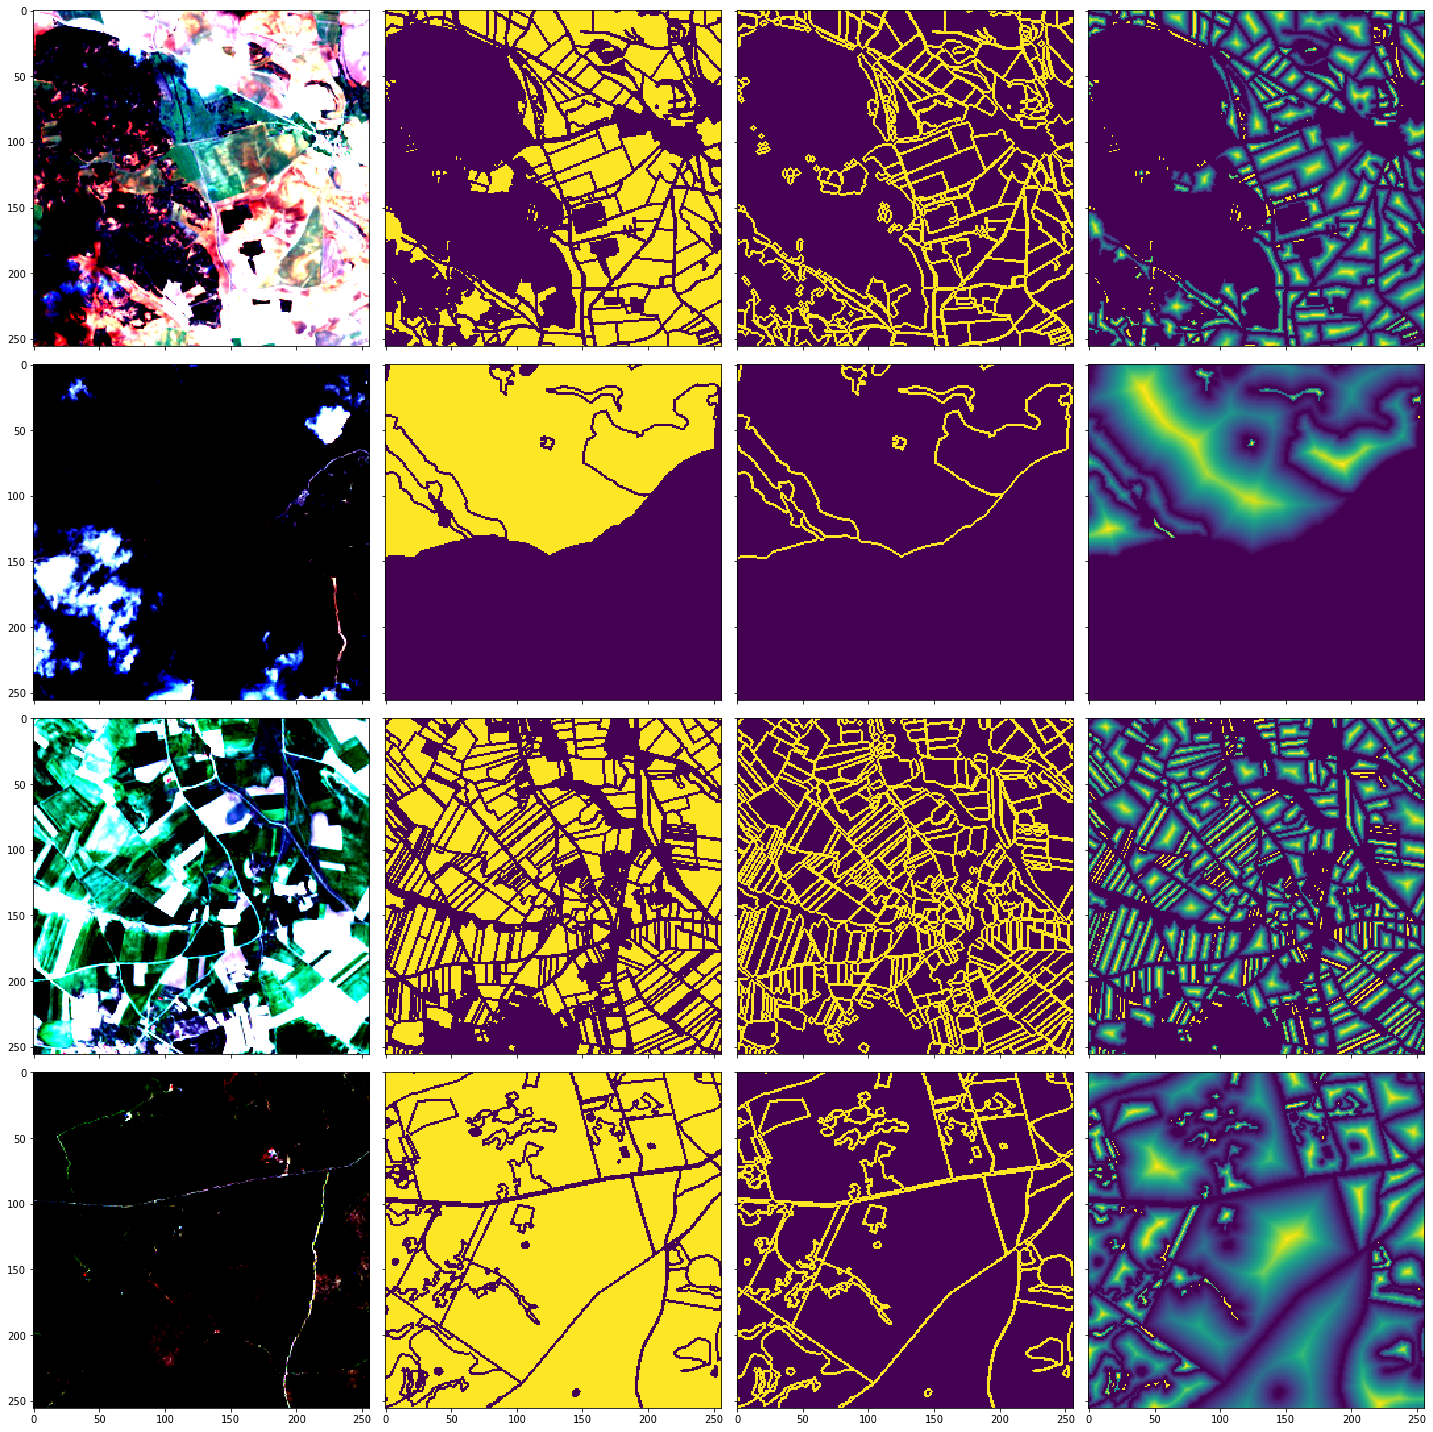

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=4, sharex='all', sharey='all', figsize=(20, 20))

for nb in np.arange(4):
    axs[nb][0].imshow(feats['features'].numpy()[nb][...,[2,1,0]])
    axs[nb][1].imshow(lbls['extent'].numpy()[nb][..., 1])
    axs[nb][2].imshow(lbls['boundary'].numpy()[nb][..., 1])
    axs[nb][3].imshow(lbls['distance'].numpy()[nb][..., 1])
    
plt.tight_layout()

In [12]:
del ds_fold_ex

### Set up model & Train in a k-fold cross-validation fashion 

The following code sets up training of `n_folds` models, for a more robust implementation. If k-fold validation is not desired, the training dataset can be build by joining all dataset folds together, and training a single model.

In [13]:
def initialise_model(config: TrainingConfig, chkpt_folder: str = None):
    """ Initialise ResUnetA model 
    
    If an existing chekpoints directory is provided, the existing weights are loaded and 
    training starts from existing state
    """
    mcc_metric = MCCMetric(default_n_classes=n_classes, default_threshold=.5)
    mcc_metric.init_from_config({'n_classes': n_classes})
    
    model = ResUnetA(training_config.model_config)
    
    model.build(dict(features=[None] + list(training_config.input_shape)))
    
    model.net.compile(
        loss={'extent':TanimotoDistanceLoss(from_logits=False),
              'boundary':TanimotoDistanceLoss(from_logits=False),
              'distance':TanimotoDistanceLoss(from_logits=False)},
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=training_config.model_config['learning_rate']),
        # comment out the metrics you don't care about
        metrics=[segmentation_metrics['accuracy'](),
                 tf.keras.metrics.MeanIoU(num_classes=training_config.n_classes)])
    
    if chkpt_folder is not None:
        model.net.load_weights(f'{chkpt_folder}/model.ckpt')
        
    return model


def initialise_callbacks(config: TrainingConfig, 
                         fold: int) -> Tuple[str, List[Callable]]:
    """ Initialise callbacks used for logging and saving of models """
    now = datetime.now().isoformat(sep='-', timespec='seconds').replace(':', '-')
    model_path = f'{training_config.model_folder}/{training_config.model_name}_fold-{fold}_{now}'

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    logs_path = os.path.join(model_path, 'logs')
    checkpoints_path = os.path.join(model_path, 'checkpoints', 'model.ckpt')


    # Tensorboard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_path,
                                                          update_freq='epoch',
                                                          profile_batch=0)

    # Checkpoint saving callback
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoints_path,
                                                             save_best_only=True,
                                                             save_freq='epoch',
                                                             save_weights_only=True)

    full_config = dict(**training_config.model_config, 
                       iterations_per_epoch=training_config.iterations_per_epoch, 
                       num_epochs=training_config.num_epochs, 
                       batch_size=training_config.batch_size,
                       model_name=f'{training_config.model_name}_{now}'
                      )

    # Save model config 
    with open(f'{model_path}/model_cfg.json', 'w') as jfile:
        json.dump(training_config.model_config, jfile)

    # initialise wandb if used
    if training_config.wandb_id:
        wandb.init(config=full_config, 
                   name=f'{training_config.model_name}-leftoutfold-{fold}',
                   project="field-delineation", 
                   sync_tensorboard=True)
        
    callbacks = [tensorboard_callback, 
                 checkpoint_callback, 
                ] + ([WandbCallback()] if training_config.wandb_id is not None else [])
    
    return model_path, callbacks 

Indices defining which dataset folds to consider

In [14]:
folds = list(range(training_config.n_folds))

folds_ids_list = [(folds[:nf] + folds[1 + nf:], [nf]) for nf in folds]
folds_ids_list

[([1, 2, 3, 4], [0]),
 ([0, 2, 3, 4], [1]),
 ([0, 1, 3, 4], [2]),
 ([0, 1, 2, 4], [3]),
 ([0, 1, 2, 3], [4])]

### Train models

For each left-out fold k:
 * join the TF dataset of the other K-1 folds
 * reserve a fraction of the joined dataset for validation
 * initialise the model, possibly starting from a pre-trained model
 * train and save the model
 * evaluate the model on the left-out k fold

In [ ]:
np.random.seed(training_config.seed)

models = []
model_paths = []

for training_ids, testing_id in folds_ids_list:
    
    left_out_fold = testing_id[0]+1
    print(f'Training model for left-out fold {left_out_fold}')
    
    # Create datasets for this fold, 3 folds for training, 1 for validation
    fold_val = np.random.choice(training_ids)
    folds_train = [tid for tid in training_ids if tid != fold_val]
    print(f'Trai folds {folds_train}, Val fold: {fold_val}, Test fold: {testing_id[0]}')
    
    ds_folds_train = [ds_folds[tid] for tid in folds_train]
    ds_train = reduce(tf.data.Dataset.concatenate, ds_folds_train)
        
    ds_val = ds_folds[fold_val]
    
    ds_val = ds_val.batch(training_config.batch_size)
    
    ds_train = ds_train.batch(training_config.batch_size)
    ds_train = ds_train.repeat()
    
    # Get model
    model = initialise_model(training_config, chkpt_folder=training_config.chkpt_folder)
    
    # Set up callbacks to monitor training
    model_path, callbacks = initialise_callbacks(training_config, 
                                                 fold=left_out_fold)
    
    print(f'\tTraining model, writing to {model_path}')
    
    model.net.fit(ds_train, 
                  validation_data=ds_val,
                  epochs=training_config.num_epochs,
                  steps_per_epoch=training_config.iterations_per_epoch,
                  callbacks=callbacks)
    
    models.append(model)
    model_paths.append(model_path)
    
    del fold_val, folds_train, ds_train, ds_val

### Upload models to bucket

When we are happy about the trained model we can upload it to bucket

In [25]:
from fs.copy import copy_dir

In [26]:
filesystem = prepare_filesystem(training_config)

In [27]:
for model_path in model_paths:
    model_name = os.path.basename(model_path)
    filesystem.makedirs(f'{training_config.model_s3_folder}/{model_name}', recreate=True)
    copy_dir(training_config.model_folder, 
             f'{model_name}',
             filesystem, 
             f'{training_config.model_s3_folder}/{model_name}')

### Create an average model from the folds

In [28]:
weights = [model.net.get_weights() for model in models]

In [33]:
avg_weights = list()

for weights_list_tuple in zip(*weights):
    avg_weights.append(np.array([np.array(weights_).mean(axis=0) 
                        for weights_ in zip(*weights_list_tuple)]))

In [46]:
avg_model = ResUnetA(training_config.model_config)
    
avg_model.build(dict(features=[None] + list(training_config.input_shape)))

avg_model.net.compile(
        loss={'extent':TanimotoDistanceLoss(from_logits=False),
              'boundary':TanimotoDistanceLoss(from_logits=False),
              'distance':TanimotoDistanceLoss(from_logits=False)},
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=training_config.model_config['learning_rate']),
        # comment out the metrics you don't care about
        metrics=[segmentation_metrics['accuracy'](),
                 tf.keras.metrics.MeanIoU(num_classes=training_config.n_classes)])

avg_model.net.set_weights(avg_weights)

Save model to local disk

In [35]:
now = datetime.now().isoformat(sep='-', timespec='seconds').replace(':', '-')
model_path = f'{training_config.model_folder}/{training_config.model_name}_avg_{now}'

if not os.path.exists(model_path):
    os.makedirs(model_path)

checkpoints_path = os.path.join(model_path, 'checkpoints', 'model.ckpt')

# Save model config 
with open(f'{model_path}/model_cfg.json', 'w') as jfile:
    json.dump(training_config.model_config, jfile)

avg_model.net.save_weights(checkpoints_path)

### Check some validation results

In [36]:
test_batch = next(iter(ds_folds[1].batch(batch_size)))

In [37]:
model = models[1]

In [39]:
predictions = model.net.predict(test_batch[0]['features'].numpy())

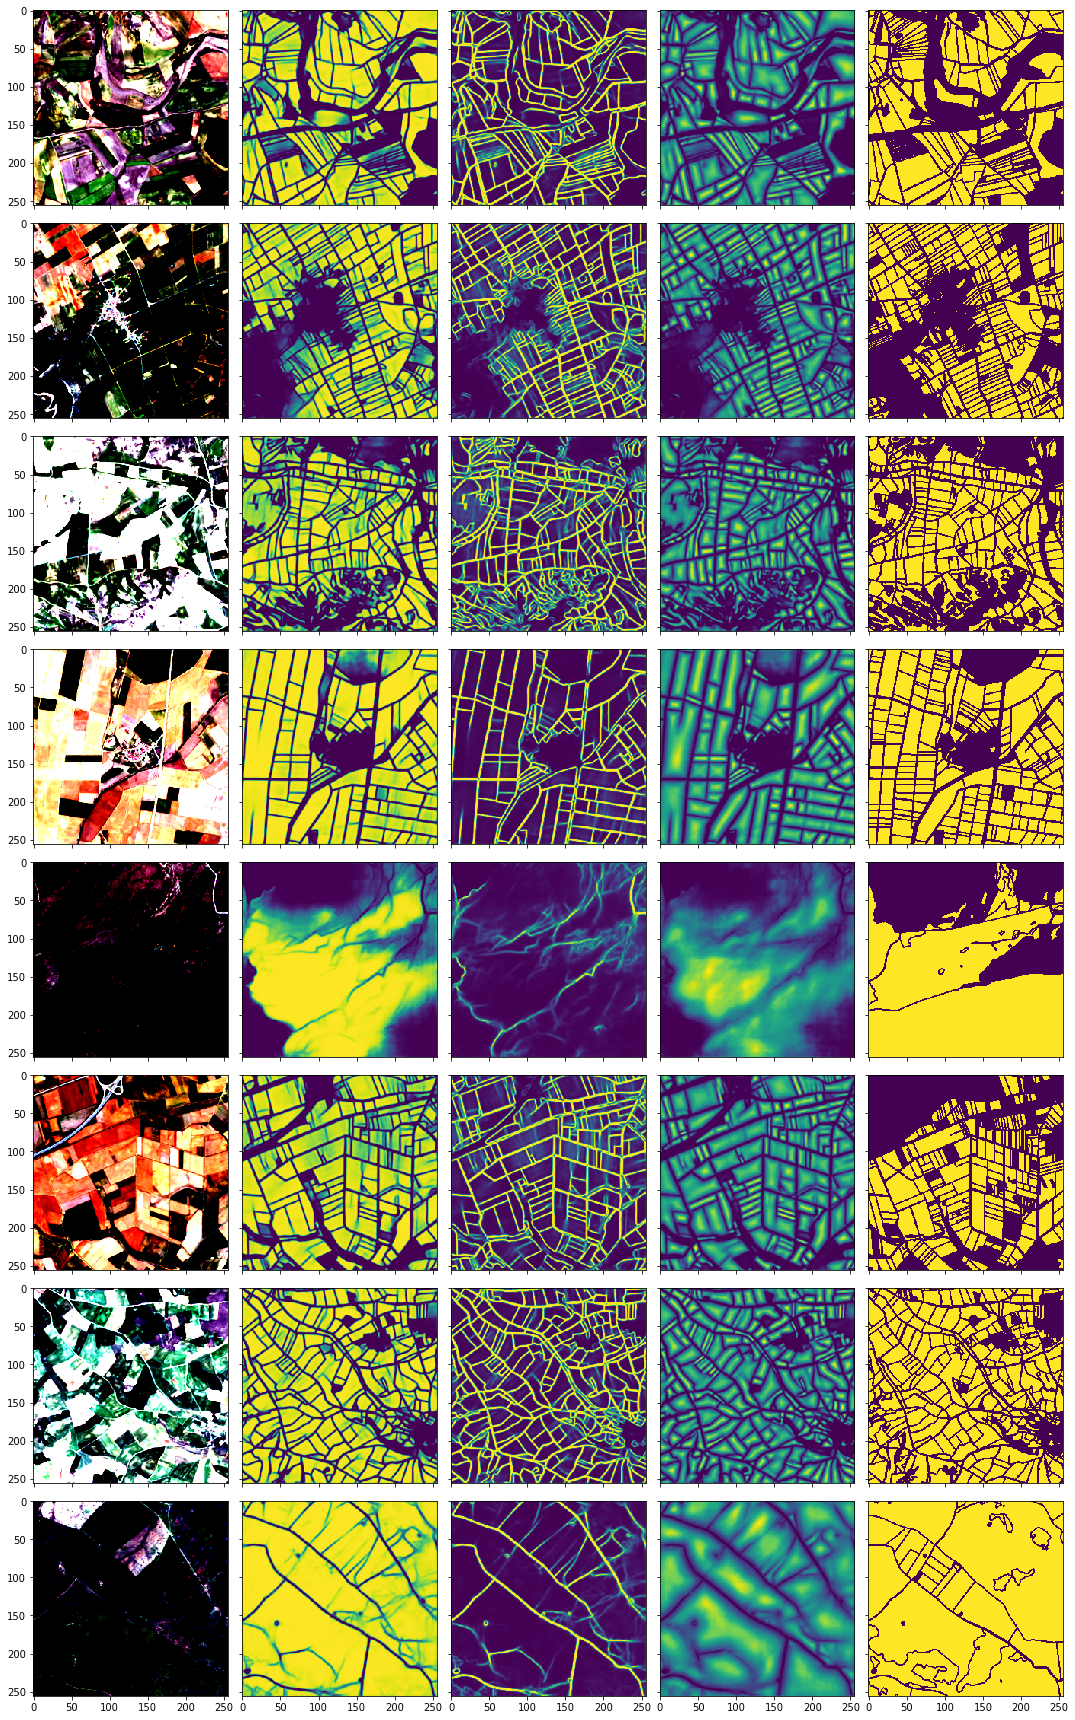

In [40]:
n_images = 8

fig, axs = plt.subplots(nrows=n_images, ncols=5, 
                        sharex='all', sharey='all', 
                        figsize=(15, 3*n_images))

for nb in np.arange(n_images):
    axs[nb][0].imshow(test_batch[0]['features'].numpy()[nb][...,[2,1,0]])
    axs[nb][1].imshow(predictions[0][nb][..., 1])
    axs[nb][2].imshow(predictions[1][nb][..., 1])
    axs[nb][3].imshow(predictions[2][nb][..., 1])
    axs[nb][4].imshow(test_batch[1]['extent'].numpy()[nb][..., 1])
    
plt.tight_layout()

Check predictions for average model

In [41]:
predictions = avg_model.net.predict(test_batch[0]['features'].numpy())

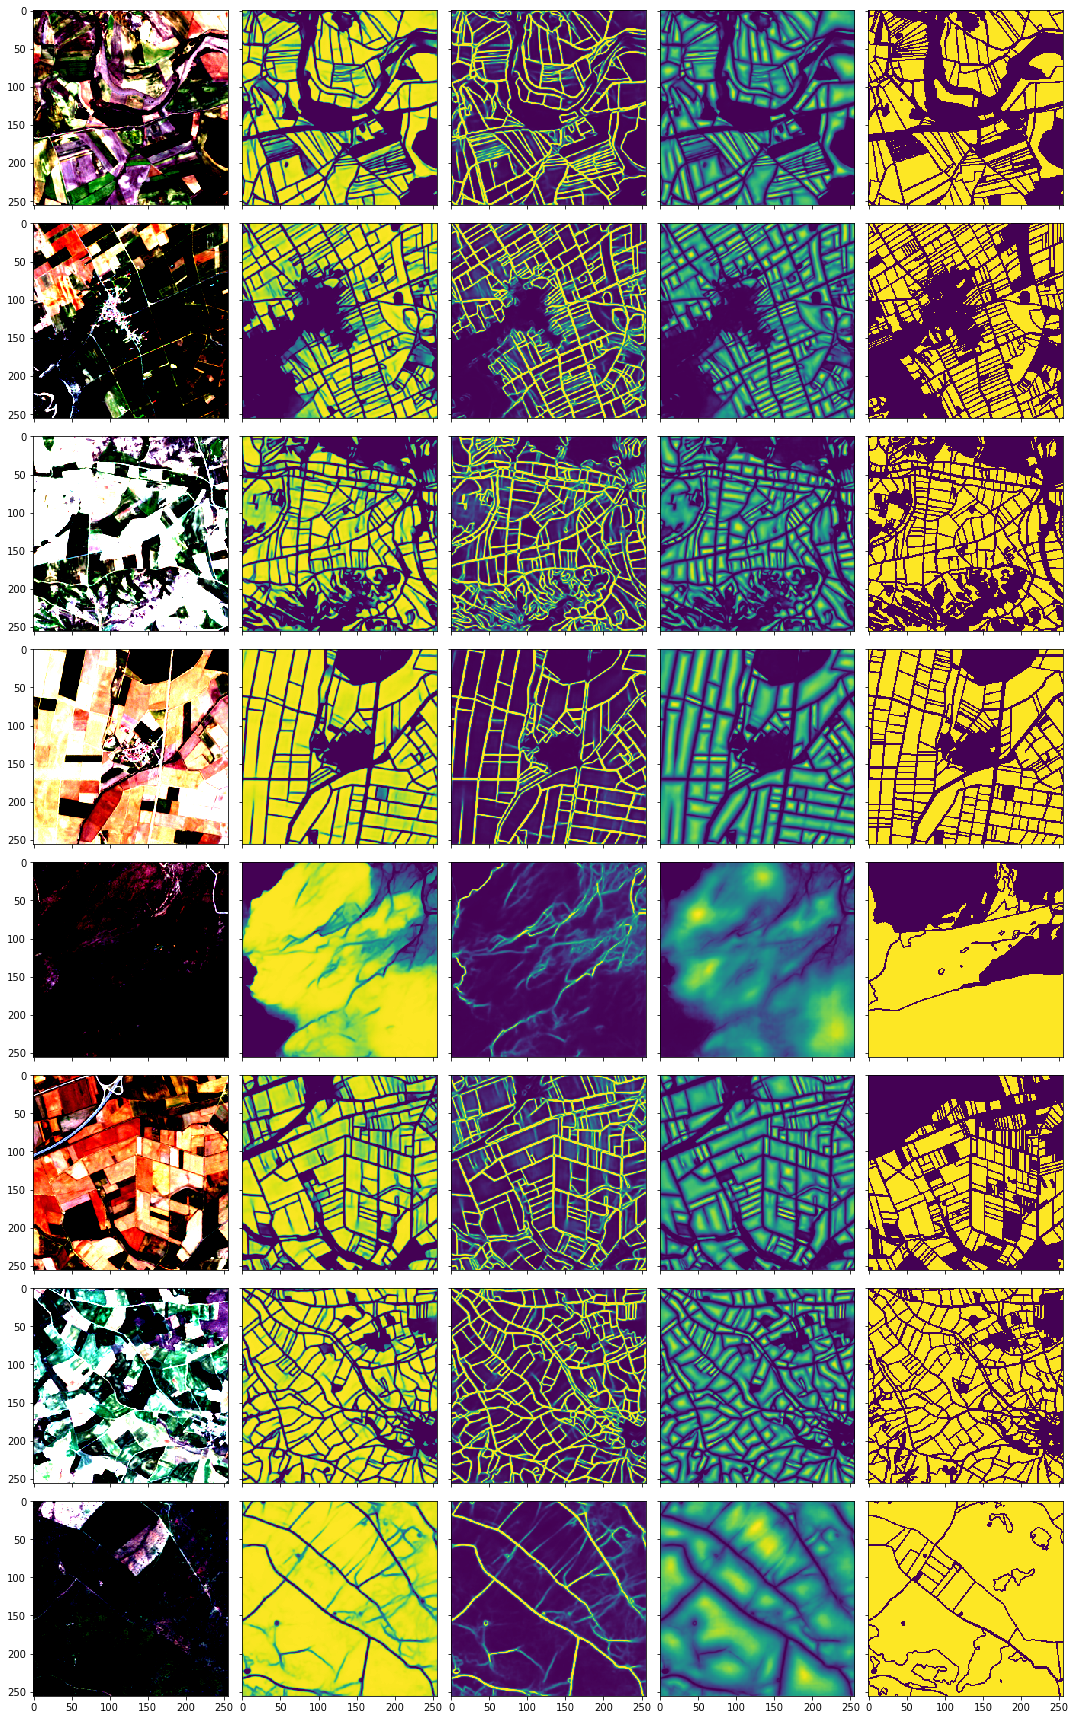

In [42]:
n_images = 8

fig, axs = plt.subplots(nrows=n_images, ncols=5, 
                        sharex='all', sharey='all', 
                        figsize=(15, 3*n_images))

for nb in np.arange(n_images):
    axs[nb][0].imshow(test_batch[0]['features'].numpy()[nb][...,[2,1,0]])
    axs[nb][1].imshow(predictions[0][nb][..., 1])
    axs[nb][2].imshow(predictions[1][nb][..., 1])
    axs[nb][3].imshow(predictions[2][nb][..., 1])
    axs[nb][4].imshow(test_batch[1]['extent'].numpy()[nb][..., 1])
    
plt.tight_layout()

## Evaluate models on test dataset

Once we are happy with the hyper-parameters, we can test the performance of the models on the left-out test dataset.

NOTE: bear in mind that this score is computed on augmented samples, for a better score estimation recreate the datasets without augmentation.

In [47]:
for _, testing_id in folds_ids_list:
    
    left_out_fold = testing_id[0]+1
    print(f'Evaluating model on left-out fold {left_out_fold}')
    
    model = models[testing_id[0]]
    model.net.evaluate(ds_folds[testing_id[0]].batch(training_config.batch_size))
    
    print(f'Evaluating average model on left-out fold {left_out_fold}')
    avg_model.net.evaluate(ds_folds[testing_id[0]].batch(training_config.batch_size))
    
    print('\n\n')

Evaluating model on left-out fold 1
516/516 [==============================] - 136s 264ms/step - loss: 1.9380 - extent_loss: 0.7132 - boundary_loss: 0.7307 - distance_loss: 0.4940 - extent_accuracy: 0.7611 - extent_mean_io_u_5: 0.2909 - boundary_accuracy: 0.8317 - boundary_mean_io_u_5: 0.2505 - distance_accuracy: 0.8102 - distance_mean_io_u_5: 0.3895
Evaluating average model on left-out fold 1
516/516 [==============================] - 136s 264ms/step - loss: 1.7998 - extent_loss: 0.6355 - boundary_loss: 0.7152 - distance_loss: 0.4492 - extent_accuracy: 0.7915 - extent_mean_io_u_6: 0.3026 - boundary_accuracy: 0.8340 - boundary_mean_io_u_6: 0.2502 - distance_accuracy: 0.8236 - distance_mean_io_u_6: 0.3896



Evaluating model on left-out fold 2
442/442 [==============================] - 114s 258ms/step - loss: 2.0220 - extent_loss: 0.7510 - boundary_loss: 0.7453 - distance_loss: 0.5257 - extent_accuracy: 0.7392 - extent_mean_io_u_1: 0.2869 - boundary_accuracy: 0.8338 - boundary_mean_io_u